<h1 align="center">Boston Housing Price Prediction - part 2 </h1>
<h2 align="center"> Multivariable regression - combine the explanatory power in the features </h2>
<h3 align="center">Rositsa Chankova</h3>

In [2]:
from sklearn.datasets import load_boston 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import boston_valuation as val
%matplotlib inline

boston_dataset = load_boston()

In [3]:
dir(boston_dataset)

['DESCR', 'data', 'data_module', 'feature_names', 'filename', 'target']

In [4]:
# Create a pandas dataframe
data = pd.DataFrame(data=boston_dataset.data, columns=boston_dataset.feature_names)

# Add column with the price (target)
data['PRICE'] = boston_dataset.target

In [5]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Regression line between each feature and the target variable individually.

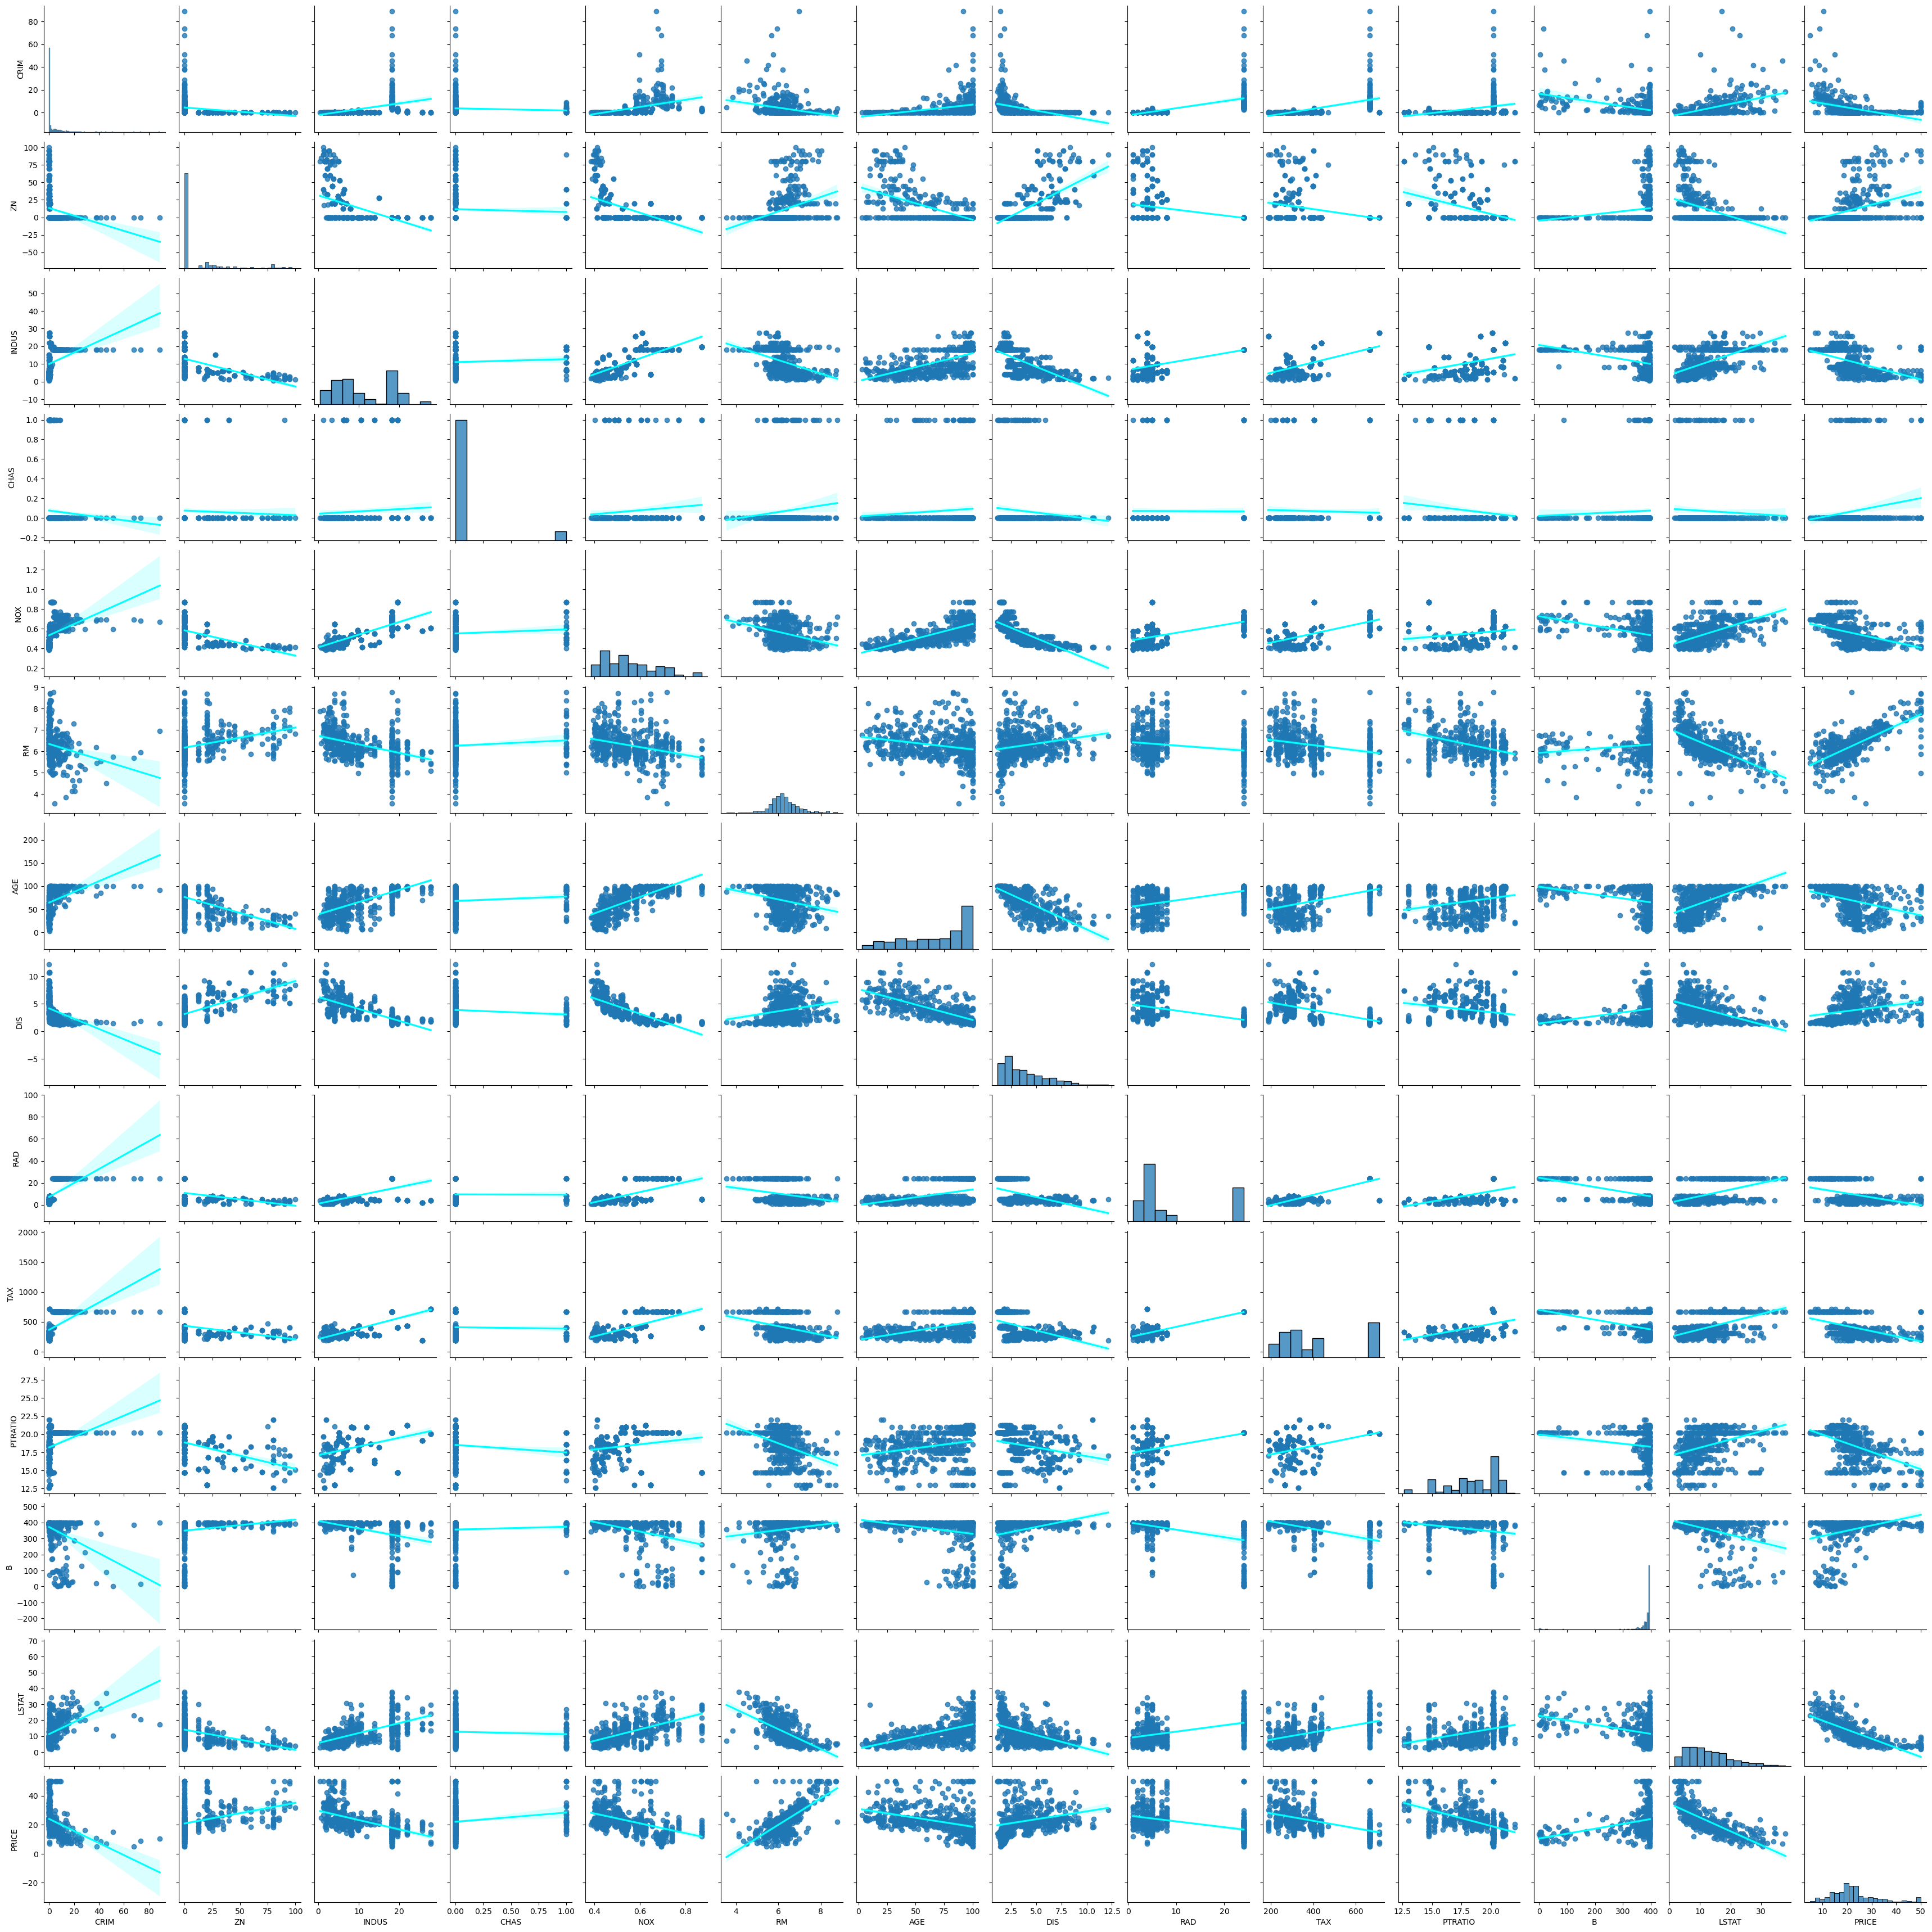

CPU times: user 2min 18s, sys: 1.25 s, total: 2min 20s
Wall time: 44.9 s


In [6]:
%%time

sns.pairplot(data, kind='reg', plot_kws={'line_kws':{'color': 'cyan'}})
plt.show()

##   1. Split Dataset - Training & Test Set

In [7]:
prices = data['PRICE']
features = data.drop('PRICE', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, 
                                                    test_size=0.2, random_state=10)

# % of training set
len(X_train)/len(features)

0.7984189723320159

In [8]:
# % of test data set
X_test.shape[0]/features.shape[0]

0.2015810276679842

## 2. Multivariable Regression

In [9]:
regr = LinearRegression()
regr.fit(X_train, y_train)

#Print r-squared for training and test datasets
print('Training data r-squared:', regr.score(X_train, y_train))
print('Test data r-squared:', regr.score(X_test, y_test))

print('Intercept', regr.intercept_)
pd.DataFrame(data=regr.coef_, index=X_train.columns, columns=['coef'])

Training data r-squared: 0.750121534530608
Test data r-squared: 0.6709339839115628
Intercept 36.53305138282439


,coef
CRIM,-0.128181
ZN,0.063198
INDUS,-0.007576
CHAS,1.974515
NOX,-16.271989
RM,3.108456
AGE,0.016292
DIS,-1.483014
RAD,0.303988
TAX,-0.012082


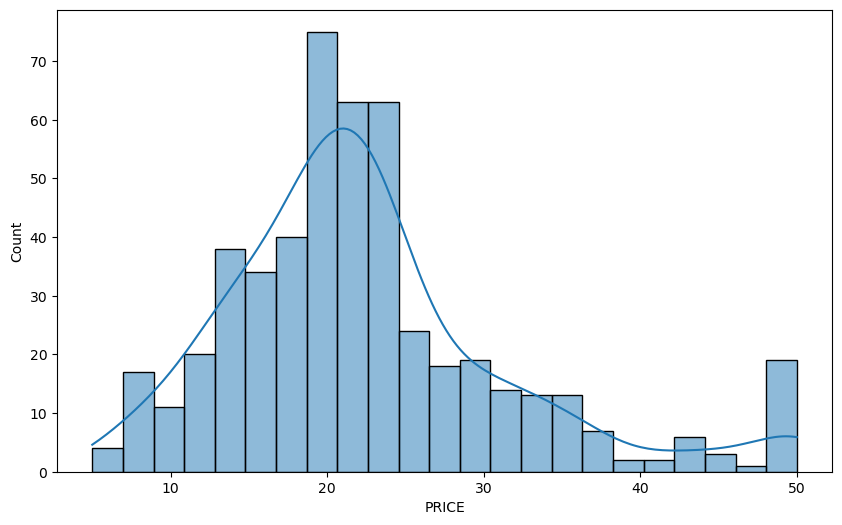

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data['PRICE'], kde=True)
plt.show()

**Data has outliers in the right**

## 3. Data Transformations

**Calculate the skew of the target values**

In [10]:
data['PRICE'].skew()

1.1080984082549072

**Shift the distribution in order to affect the large house prices in the tail more than the rest.**

In [11]:
y_log = np.log(data['PRICE']) 
y_log.tail()

501    3.109061
502    3.025291
503    3.173878
504    3.091042
505    2.476538
Name: PRICE, dtype: float64

**The skew of -0.33 is a lot closer to zero than with a skew of 1.1.**

In [12]:
y_log.skew() 

-0.33032129530987864

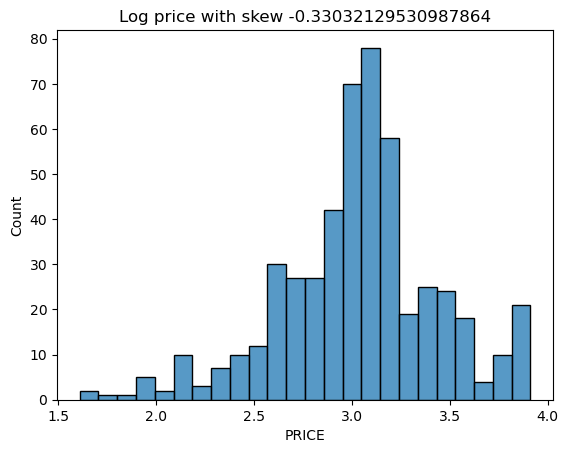

In [14]:
sns.histplot(y_log)
plt.title(f'Log price with skew {y_log.skew()}')
plt.show()

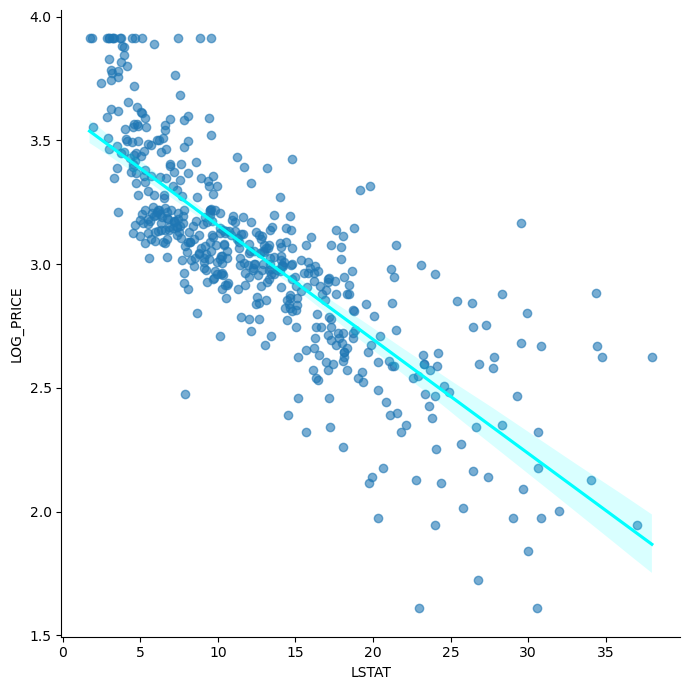

In [15]:
transformed_data = features
transformed_data['LOG_PRICE'] = y_log

sns.lmplot(x='LSTAT', y='LOG_PRICE', data=transformed_data, height=7, 
           scatter_kws={'alpha': 0.6}, line_kws={'color':'cyan'})
plt.show()

## Regression using log prices

In [17]:
prices = np.log(data['PRICE']) # Use log prices
features = data.drop('PRICE', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, 
                                                    test_size=0.2, random_state=10)

regr = LinearRegression()
regr.fit(X_train, y_train)

print('Training data r-squared:', regr.score(X_train, y_train))
print('Test data r-squared:', regr.score(X_test, y_test))

print('Intercept', regr.intercept_)
pd.DataFrame(data=regr.coef_, index=X_train.columns, columns=['coef'])

Training data r-squared: 0.7930234826697583
Test data r-squared: 0.7446922306260724
Intercept 4.05994387177519


,coef
CRIM,-0.010672
ZN,0.001579
INDUS,0.002030
CHAS,0.080331
NOX,-0.704068
RM,0.073404
AGE,0.000763
DIS,-0.047633
RAD,0.014565
TAX,-0.000645


**The data transformation experiment was a success. 
Reducing the skew in the distribution of target values allowed to improve the model, and the result is a higher $R-squared$ and a better fit.**

**Now the coefficient on the Charles River, a dummy variable, is 0.08.**

**In order to figure out how much more people are willing to pay to be close to the river according to this model, what one has to do is reverse the log transformation into actual dollar prices.**

In [18]:
# Charles River Property Premium
np.e**0.080475 #people are willing to pay approximately 1084 and dollars more to live close to the river.

1.0838017512597784

## p-values & Evaluating Coefficients

**A regression coefficients that tells about its significance is called the p-value.**

**If the p-value is less than a certain threshold, that threshold being 0.05, then the result is deemed statistically significant and when the p-value is greater than 0.05, then this result is considered to be not statistically significant.**

In [19]:
X_incl_const = sm.add_constant(X_train)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

results.params
results.pvalues

const      1.188124e-52
CRIM       1.753774e-14
ZN         8.607727e-03
INDUS      4.445368e-01
CHAS       3.824015e-02
NOX        2.729624e-05
RM         1.089112e-04
AGE        2.091731e-01
DIS        1.812912e-07
RAD        3.746363e-07
TAX        5.145680e-05
PTRATIO    7.549821e-09
B          6.326839e-06
LSTAT      3.105305e-37
dtype: float64

In [20]:
pd.DataFrame({'coef': results.params, 'p-value': round(results.pvalues, 3)})

,coef,p-value
const,4.059944,0.000
CRIM,-0.010672,0.000
ZN,0.001579,0.009
INDUS,0.002030,0.445
CHAS,0.080331,0.038
NOX,-0.704068,0.000
RM,0.073404,0.000
AGE,0.000763,0.209
DIS,-0.047633,0.000
RAD,0.014565,0.000


**INDUS and AGE feature failed the test. These two features do not appear to add much additional information. All the others are indeed statistically significant.**

### Testing for Multicollinearity - when two or more predictor variables in a regression are highly related to one another.


- There is a loss of reliability in the estimates of the effects for the individual features, in particular the features that are affected.
- There is a high variability in the coefficient estimates for small changes in the model, for example, adding or removing a feature can have dramatic effects.

- The estimates of the theta values in the model become unstable and can even switch signs from positive to negative and vice versa.

- The third effect of the problem is that the findings are strange or misleading or don't make sense.

### Variance inflation factor - a measure of collinearity among the features within a multiple regression.

**This is a number that quantifies the severity of multicollinearity similar to a number with the p-values. Have to compare it to a threshold.**

In [21]:
variance_inflation_factor(exog=X_incl_const.values, exog_idx=1)
#type(X_incl_const)

1.7145250443932485

In [22]:
# Print out the number of columns in X_incl_const
len(X_incl_const.columns)
X_incl_const.shape[1]

14

$$ TAX = \alpha _0 + \alpha _1 RM + \alpha _2 NOX + ... + \alpha _{12}LSTAT $$

$$ VIF _{TAX} = \frac{1}{(1 - R _{TAX} ^ 2)} $$

**Regression is being run of all the other features against TAX and then the $R-squared$ of that regression is used to calculate the variance inflation factor.  1 divided by $(1 - R^2)$ of this regression is the variance inflation factor for the TAX feature, so that $R-squared$ here is the $R-squared$ from trying to explain the tax feature in terms of all the other features in the dataset.**

In [23]:
# A loop that prints out all the VIFs for all the features
for i in range(X_incl_const.shape[1]):
    print(variance_inflation_factor(exog=X_incl_const.values, exog_idx=i))
print('All done!')

597.5487126763895
1.7145250443932485
2.3328224265597584
3.943448822674636
1.0788133385000576
4.410320817897634
1.8404053075678568
3.3267660823099408
4.222923410477865
7.314299817005058
8.508856493040817
1.839911632651406
1.3386713255364715
2.812544292793034
All done!


**Calculate a variance inflation factor for all the different features by swapping out this TAX for RM one gets the variance inflation factor for RM, going to calculate 13 different variants inflation factors.**

In [24]:
vif = [] # empty list
for i in range(X_incl_const.shape[1]):
    vif.append(variance_inflation_factor(exog=X_incl_const.values, exog_idx=i))
print(vif)

[597.5487126763895, 1.7145250443932485, 2.3328224265597584, 3.943448822674636, 1.0788133385000576, 4.410320817897634, 1.8404053075678568, 3.3267660823099408, 4.222923410477865, 7.314299817005058, 8.508856493040817, 1.839911632651406, 1.3386713255364715, 2.812544292793034]


In [25]:
vif = [variance_inflation_factor(exog=X_incl_const.values, 
                                 exog_idx=i) for i in range(X_incl_const.shape[1])]

pd.DataFrame({'coef_name': X_incl_const.columns, 
             'vif': np.around(vif, 2)})

,coef_name,vif
0,const,597.55
1,CRIM,1.71
2,ZN,2.33
3,INDUS,3.94
4,CHAS,1.08
5,NOX,4.41
6,RM,1.84
7,AGE,3.33
8,DIS,4.22
9,RAD,7.31


**For the variance inflation factors, the scientific consensus seems to be that the threshold is around 10, meaning any feature that has a VIF over 10 would be considered problematic and would need closer inspection.**

## Model Simplification & the Baysian Information Criterion (BIC)

**The Baysian information criterion is a way to measure complexity. It's basically a number that allows to compare two different models.**

In [26]:
# Original model with log prices and all features

X_incl_const = sm.add_constant(X_train)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

org_coef = pd.DataFrame({'coef': results.params, 'p-value': round(results.pvalues, 3)})

# Challenge: find and check official docs for results object and print out BIC & r-squared
print('BIC is', results.bic)
print('R-squared is', results.rsquared)

BIC is -139.74997769478875
R-squared is 0.7930234826697582


In [27]:
# Reduced model #1 excluding INDUS
X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['INDUS'], axis=1)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

coef_minus_indus = pd.DataFrame({'coef': results.params, 'p-value': round(results.pvalues, 3)})

print('BIC is', results.bic)
print('R-squared is', results.rsquared)

BIC is -145.14508855591163
R-squared is 0.7927126289415163


In [28]:
# Reduced model #2 excluding INDUS and AGE
X_incl_const = sm.add_constant(X_train)
X_incl_const = X_incl_const.drop(['INDUS', 'AGE'], axis=1)

model = sm.OLS(y_train, X_incl_const)
results = model.fit()

reduced_coef = pd.DataFrame({'coef': results.params, 'p-value': round(results.pvalues, 3)})

print('BIC is', results.bic)
print('R-squared is', results.rsquared)

BIC is -149.49934294224678
R-squared is 0.7918657661852815


In [29]:
frames = [org_coef, coef_minus_indus, reduced_coef]
pd.concat(frames, axis=1)

,coef,p-value,coef,p-value,coef,p-value
const,4.059944,0.000,4.056231,0.000,4.035922,0.000
CRIM,-0.010672,0.000,-0.010721,0.000,-0.010702,0.000
ZN,0.001579,0.009,0.001551,0.010,0.001461,0.014
INDUS,0.002030,0.445,NaN,NaN,NaN,NaN
CHAS,0.080331,0.038,0.082795,0.032,0.086449,0.025
NOX,-0.704068,0.000,-0.673365,0.000,-0.616448,0.000
RM,0.073404,0.000,0.071739,0.000,0.076133,0.000
AGE,0.000763,0.209,0.000766,0.207,NaN,NaN
DIS,-0.047633,0.000,-0.049394,0.000,-0.052692,0.000
RAD,0.014565,0.000,0.014014,0.000,0.013743,0.000


**Despite tweaking the model all the coefficients are remarkably consistent.  The numbers change somewhat but they
don't switch signs, they don't change drastically. These are all very stable coefficient estimates.**

## Residuals & Residual Plots

**There usually will be a difference between the predicted value and the actual true value. What is left when subtract the predicted value from the observed target value is called the residual.**

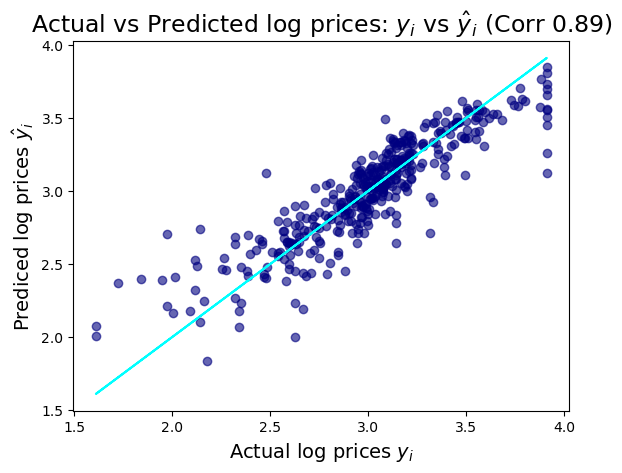

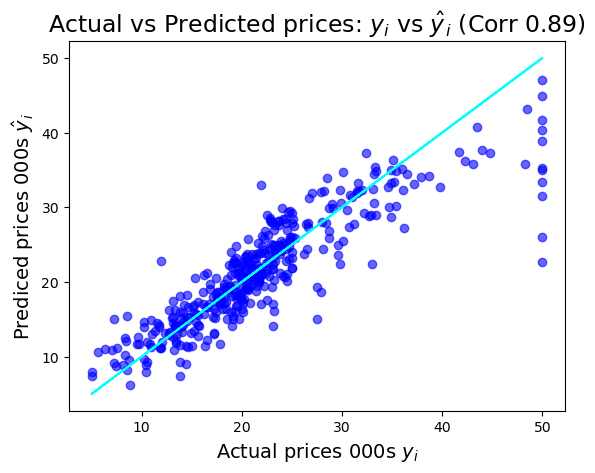

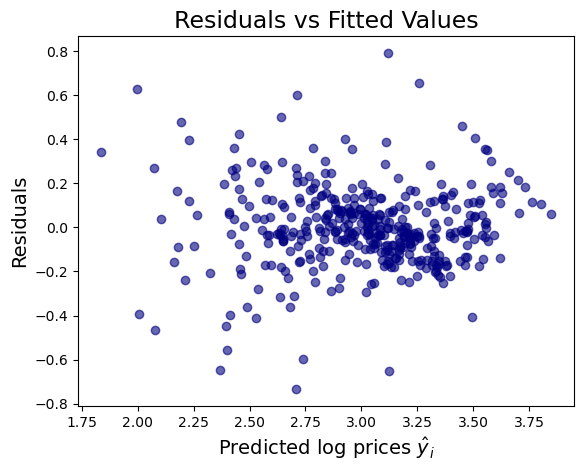

In [30]:
# Modified model: transformed (using log prices) & simplified (dropping two features)
prices = np.log(data['PRICE']) # Use log prices
features = data.drop(['PRICE', 'INDUS', 'AGE'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, 
                                                    test_size=0.2, random_state=10)

# Using Statsmodel
X_incl_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_incl_const)
results = model.fit()

# Residuals
# residuals = y_train - results.fittedvalues
# results.resid

# Graph of Actual vs. Predicted Prices
corr = round(y_train.corr(results.fittedvalues), 2)
plt.scatter(x=y_train, y=results.fittedvalues, c='navy', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')

plt.xlabel('Actual log prices $y _i$', fontsize=14)
plt.ylabel('Prediced log prices $\hat y _i$', fontsize=14)
plt.title(f'Actual vs Predicted log prices: $y _i$ vs $\hat y_i$ (Corr {corr})', fontsize=17)

plt.show()

plt.scatter(x=np.e**y_train, y=np.e**results.fittedvalues, c='blue', alpha=0.6)
plt.plot(np.e**y_train, np.e**y_train, color='cyan')

plt.xlabel('Actual prices 000s $y _i$', fontsize=14)
plt.ylabel('Prediced prices 000s $\hat y _i$', fontsize=14)
plt.title(f'Actual vs Predicted prices: $y _i$ vs $\hat y_i$ (Corr {corr})', fontsize=17)

plt.show()

# Residuals vs Predicted values

plt.scatter(x=results.fittedvalues, y=results.resid, c='navy', alpha=0.6)

plt.xlabel('Predicted log prices $\hat y _i$', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Fitted Values', fontsize=17)

plt.show()

# Mean Squared Error & R-Squared
reduced_log_mse = round(results.mse_resid, 3)
reduced_log_rsquared = round(results.rsquared, 3)

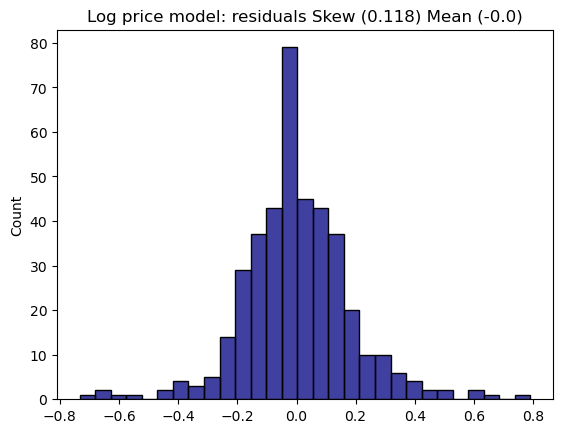

In [31]:
# Distribution of Residuals (log prices) - checking for normality
resid_mean = round(results.resid.mean(), 3)
resid_skew = round(results.resid.skew(), 3)

sns.histplot(results.resid, color='navy')
plt.title(f'Log price model: residuals Skew ({resid_skew}) Mean ({resid_mean})')
plt.show()

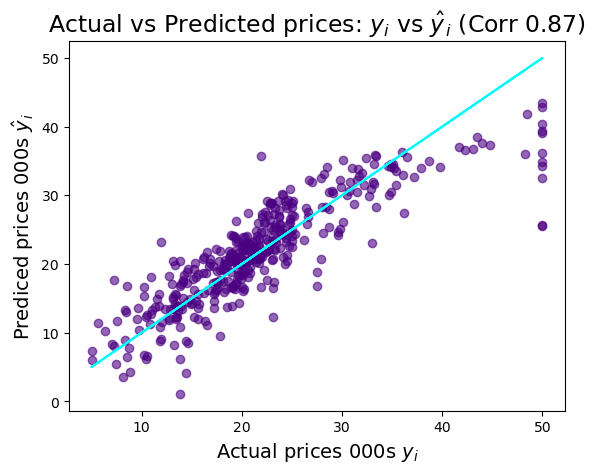

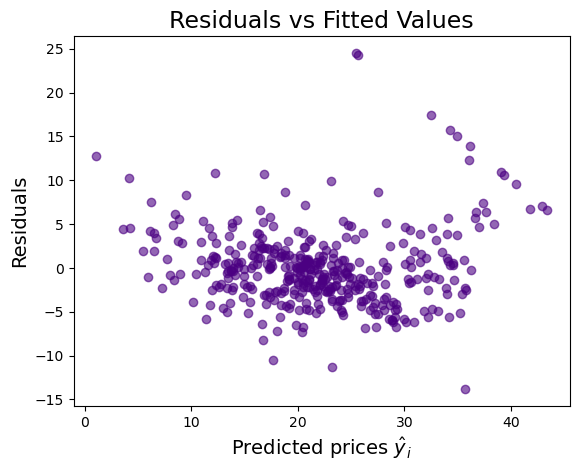

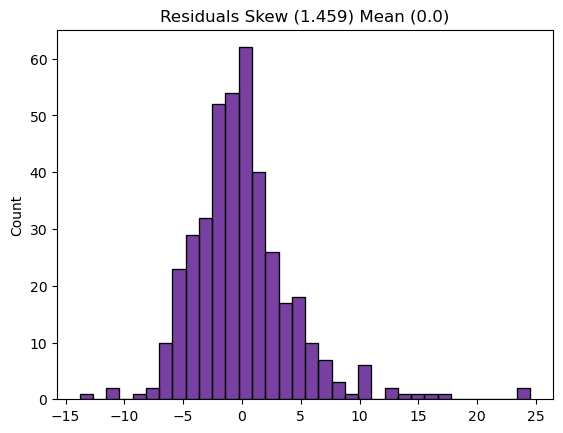

In [32]:
# Original model: normal prices & all features
prices = data['PRICE']
features = data.drop(['PRICE'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, 
                                                    test_size=0.2, random_state=10)

X_incl_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_incl_const)
results = model.fit()

# Graph of Actual vs. Predicted Prices
corr = round(y_train.corr(results.fittedvalues), 2)
plt.scatter(x=y_train, y=results.fittedvalues, c='indigo', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')

plt.xlabel('Actual prices 000s $y _i$', fontsize=14)
plt.ylabel('Prediced prices 000s $\hat y _i$', fontsize=14)
plt.title(f'Actual vs Predicted prices: $y _i$ vs $\hat y_i$ (Corr {corr})', fontsize=17)

plt.show()

# Residuals vs Predicted values
plt.scatter(x=results.fittedvalues, y=results.resid, c='indigo', alpha=0.6)

plt.xlabel('Predicted prices $\hat y _i$', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Fitted Values', fontsize=17)

plt.show()

# Residual Distribution Chart
resid_mean = round(results.resid.mean(), 3)
resid_skew = round(results.resid.skew(), 3)

sns.histplot(results.resid, color='indigo')
plt.title(f'Residuals Skew ({resid_skew}) Mean ({resid_mean})')
plt.show()

# Mean Squared Error & R-Squared
full_normal_mse = round(results.mse_resid, 3)
full_normal_rsquared = round(results.rsquared, 3)

Compared with the log prices, the cloud of residuals looks almost like it's got a little bit of a parabolic shape to it and doesn't look entirely random. This provides further justification that the log transformation for the target values was appropriate.





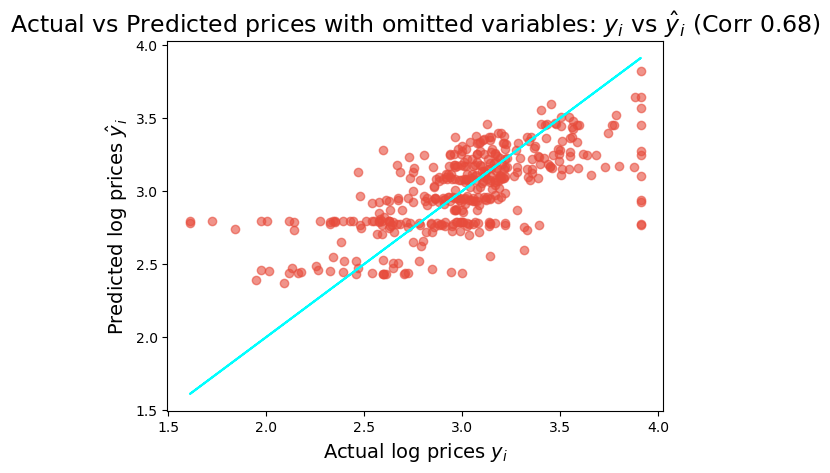

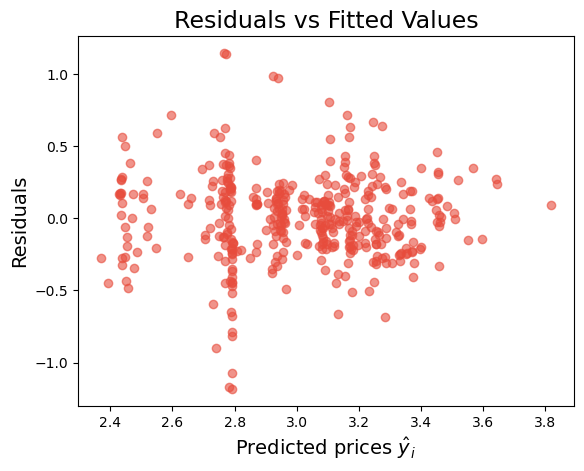

In [33]:
# Model Omitting Key Features using log prices
prices = np.log(data['PRICE'])
features = data.drop(['PRICE', 'INDUS', 'AGE', 'LSTAT', 'RM', 'NOX', 'CRIM'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, prices, 
                                                    test_size=0.2, random_state=10)

X_incl_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_incl_const)
results = model.fit()

# Graph of Actual vs. Predicted Prices
corr = round(y_train.corr(results.fittedvalues), 2)
plt.scatter(x=y_train, y=results.fittedvalues, c='#e74c3c', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')

plt.xlabel('Actual log prices $y _i$', fontsize=14)
plt.ylabel('Predicted log prices $\hat y _i$', fontsize=14)
plt.title(f'Actual vs Predicted prices with omitted variables: $y _i$ vs $\hat y_i$ (Corr {corr})', fontsize=17)

plt.show()

# Residuals vs Predicted values
plt.scatter(x=results.fittedvalues, y=results.resid, c='#e74c3c', alpha=0.6)

plt.xlabel('Predicted prices $\hat y _i$', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Fitted Values', fontsize=17)

plt.show()

# Mean Squared Error & R-Squared
omitted_var_mse = round(results.mse_resid, 3)
omitted_var_rsquared = round(results.rsquared, 3)

In [34]:
pd.DataFrame({'R-Squared': [reduced_log_rsquared, full_normal_rsquared, omitted_var_rsquared],
             'MSE': [reduced_log_mse, full_normal_mse, omitted_var_mse], 
             'RMSE': np.sqrt([reduced_log_mse, full_normal_mse, omitted_var_mse])}, 
            index=['Reduced Log Model', 'Full Normal Price Model', 'Omitted Var Model'])

,R-Squared,MSE,RMSE
Reduced Log Model,0.792,0.035,0.187083
Full Normal Price Model,0.750,19.921,4.463295
Omitted Var Model,0.460,0.090,0.300000


In [35]:
# The estimate for a house price is $30,000. Calculate the upper and lower bound
# for a 95% prediction interval using the reduced log model

print('1 s.d. in log prices is', np.sqrt(reduced_log_mse))
print('2 s.d. in log prices is', 2*np.sqrt(reduced_log_mse))

upper_bound = np.log(30) + 2*np.sqrt(reduced_log_mse)
print('The upper bound in log prices for a 95% prediction interval is ', upper_bound)
print('The upper bound in normal prices is $', np.e**upper_bound * 1000)

lower_bound = np.log(30) - 2*np.sqrt(reduced_log_mse)
print('The lower bound in log prices for a 95% prediction interval is ', lower_bound)
print('The lower bound in normal prices is $', np.e**lower_bound * 1000)

1 s.d. in log prices is 0.18708286933869708
2 s.d. in log prices is 0.37416573867739417
The upper bound in log prices for a 95% prediction interval is  3.7753631203395495
The upper bound in normal prices is $ 43613.34233239937
The lower bound in log prices for a 95% prediction interval is  3.0270316429847615
The lower bound in normal prices is $ 20635.886906824155


In [36]:
30000 + np.e**(2*np.sqrt(reduced_log_mse)) * 1000 # Wrong! Add first. Transform afterwards. 

31453.778077746647

In [37]:
val.get_dollar_estimate(8, 15, False)

The estimated property value is 755000.0.
At 95% confidence the valuation range is
USD 519000.0 at the lower end to USD 1099000.0 at the high end.


/Users/rositsa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
